# Benchmark Results Analysis

## Attempt 1

### Imports and Data Reader

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.inter_rater import fleiss_kappa
from scipy.stats import binomtest
from IPython.display import display
import Levenshtein

In [2]:
# Function to read and preprocess the data
def read_data(file_path):
    df = pd.read_csv(file_path)
    judge_columns = ['Claude Verdict', 'Cohere Verdict', 'Gemini Verdict', 'Qwen Verdict', 'LLaMA Verdict']
    verdict_mapping = {'Basic': 0, 'Enhanced': 1}
    for col in judge_columns + ['Final Verdict']:
        df[col] = df[col].map(verdict_mapping)
    return df, judge_columns

df, judge_columns = read_data('benchmark_results.csv')

### Charts

#### Overall Performance Metrics

In [3]:

def overall_performance_metrics(df, judge_columns):
    # Calculate win rate
    win_rate = df['Final Verdict'].mean()
    print(f"Enhanced method win rate: {win_rate * 100:.2f}%")
    
    # Number of Enhanced wins
    enhanced_wins = (df['Final Verdict'] == 1).sum()
    total = len(df)
    
    # Binomial test
    result = binomtest(enhanced_wins, n=total, p=0.5, alternative='two-sided')
    print(f"Binomial test p-value: {result.pvalue:.4f}")

overall_performance_metrics(df, judge_columns)

Enhanced method win rate: 61.14%
Binomial test p-value: 0.0000


#### Inter-Rater Agreement Matrix

Agreement Counts Matrix:


,Claude Verdict,Cohere Verdict,Gemini Verdict,Qwen Verdict,LLaMA Verdict
Claude Verdict,1050,717,663,748,661
Cohere Verdict,717,1050,722,645,602
Gemini Verdict,663,722,1050,521,464
Qwen Verdict,748,645,521,1050,783
LLaMA Verdict,661,602,464,783,1050



Agreement Percentages Matrix:


,Claude Verdict,Cohere Verdict,Gemini Verdict,Qwen Verdict,LLaMA Verdict
Claude Verdict,100.00%,68.29%,63.14%,71.24%,62.95%
Cohere Verdict,68.29%,100.00%,68.76%,61.43%,57.33%
Gemini Verdict,63.14%,68.76%,100.00%,49.62%,44.19%
Qwen Verdict,71.24%,61.43%,49.62%,100.00%,74.57%
LLaMA Verdict,62.95%,57.33%,44.19%,74.57%,100.00%


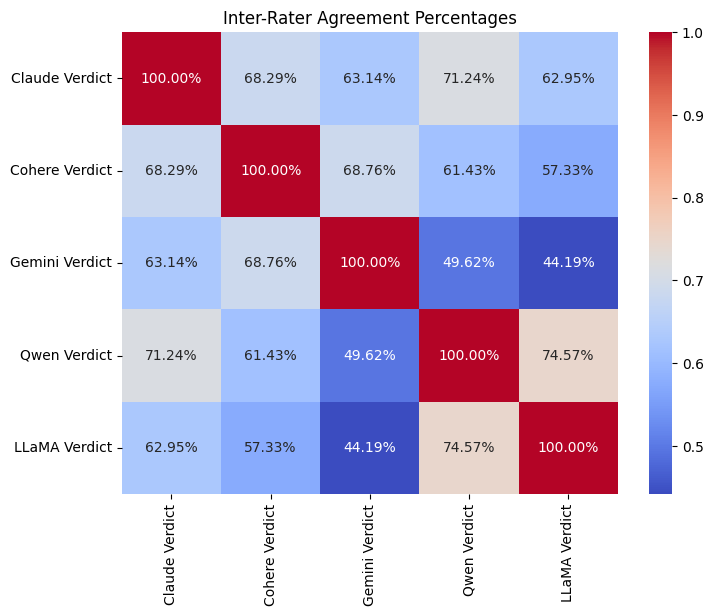

Fleiss' Kappa: 0.2313


In [4]:
def inter_rater_agreement(df, judge_columns):
    # Initialize matrices
    n_judges = len(judge_columns)
    agreement_counts = np.zeros((n_judges, n_judges), dtype=int)
    agreement_percentages = np.zeros((n_judges, n_judges))
    total_items = len(df)
    
    # Calculate agreements
    for i in range(n_judges):
        for j in range(n_judges):
            agreements = np.sum(df[judge_columns[i]] == df[judge_columns[j]])
            agreement_counts[i, j] = agreements
            agreement_percentages[i, j] = agreements / total_items
    
    # Create DataFrames for display
    counts_df = pd.DataFrame(agreement_counts, index=judge_columns, columns=judge_columns)
    percentages_df = pd.DataFrame(agreement_percentages, index=judge_columns, columns=judge_columns)
    
    # Display counts matrix
    print("Agreement Counts Matrix:")
    display(counts_df)
    
    # Display percentages matrix
    print("\nAgreement Percentages Matrix:")
    display(percentages_df.style.format("{:.2%}"))
    
    # Plot heatmap of percentages
    plt.figure(figsize=(8, 6))
    sns.heatmap(percentages_df, annot=True, fmt=".2%", xticklabels=judge_columns, yticklabels=judge_columns, cmap='coolwarm')
    plt.title('Inter-Rater Agreement Percentages')
    plt.show()
    
    # Calculate Fleiss' Kappa
    ratings = df[judge_columns].values
    category_counts = []
    for row in ratings:
        counts = [np.sum(row == 0), np.sum(row == 1)]
        category_counts.append(counts)
    kappa = fleiss_kappa(np.array(category_counts))
    print(f"Fleiss' Kappa: {kappa:.4f}")


inter_rater_agreement(df, judge_columns)

#### Judge-Specific Analysis

Claude Verdict prefers Enhanced method 59.52% of the time.
Cohere Verdict prefers Enhanced method 53.52% of the time.
Gemini Verdict prefers Enhanced method 50.67% of the time.
Qwen Verdict prefers Enhanced method 58.95% of the time.
LLaMA Verdict prefers Enhanced method 58.29% of the time.


C:\Users\serha\AppData\Local\Temp\ipykernel_5696\2505114897.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=judge_columns, y=prefs, palette='viridis')


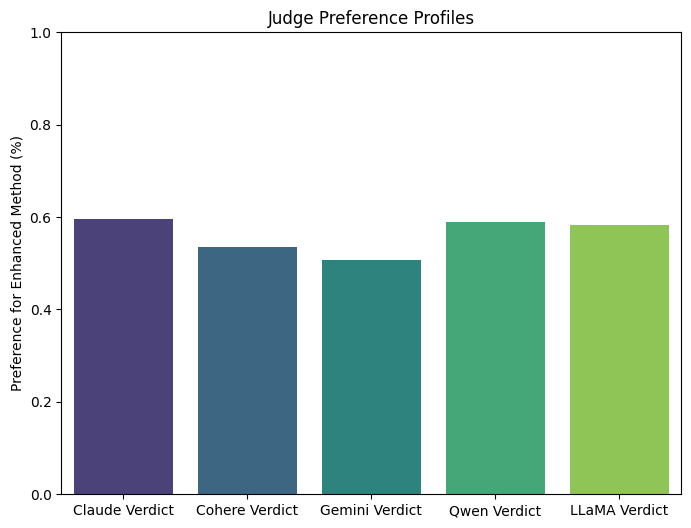

In [5]:
def judge_specific_analysis(df, judge_columns):
    # Preference profiles
    preferences = {}
    for judge in judge_columns:
        enhanced_pref = df[judge].mean()
        preferences[judge] = enhanced_pref
        print(f"{judge} prefers Enhanced method {enhanced_pref * 100:.2f}% of the time.")
    
    # Bias assessment plot
    plt.figure(figsize=(8, 6))
    prefs = [preferences[judge] for judge in judge_columns]
    sns.barplot(x=judge_columns, y=prefs, palette='viridis')
    plt.ylabel('Preference for Enhanced Method (%)')
    plt.title('Judge Preference Profiles')
    plt.ylim(0, 1)
    plt.show()

judge_specific_analysis(df, judge_columns)

#### Error and Case Study Analysis

In [6]:
def error_and_case_study_analysis(df):
    # Identify cases where judges disagreed
    df['Disagreement'] = df.apply(lambda row: len(set([row[judge] for judge in judge_columns])) > 1, axis=1)
    disagreements = df[df['Disagreement']]
    
    # Print some examples
    print("Examples of Disagreements Among Judges:")
    for idx, row in disagreements.head(3).iterrows():
        print(f"\nIndex: {row['Index']}")
        print(f"Context: {row['Context']}")
        print(f"Basic Question: {row['Basic Question']}")
        print(f"Enhanced Question: {row['Enhanced Question']}")
        for judge in judge_columns:
            verdict = 'Enhanced' if row[judge] == 1 else 'Basic'
            print(f"{judge} Verdict: {verdict}")
    
    pass  # Placeholder for error categorization

error_and_case_study_analysis(df)

Examples of Disagreements Among Judges:

Index: 36048
Context: King County Metro provides frequent stop bus service within the city and surrounding county, as well as a South Lake Union Streetcar line between the South Lake Union neighborhood and Westlake Center in downtown. Seattle is one of the few cities in North America whose bus fleet includes electric trolleybuses. Sound Transit currently provides an express bus service within the metropolitan area; two Sounder commuter rail lines between the suburbs and downtown; its Central Link light rail line, which opened in 2009, between downtown and Sea-Tac Airport gives the city its first rapid transit line that has intermediate stops within the city limits. Washington State Ferries, which manages the largest network of ferries in the United States and third largest in the world, connects Seattle to Bainbridge and Vashon Islands in Puget Sound and to Bremerton and Southworth on the Kitsap Peninsula.
Basic Question: Which islands can be re

#### Visualization of Key Results

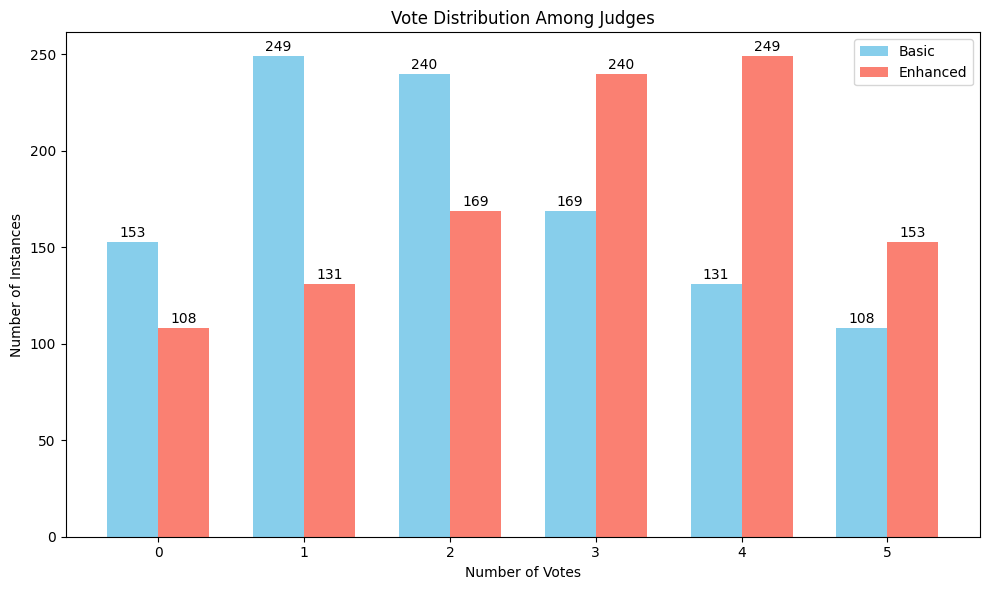

In [7]:
def visualization_of_key_results(df, judge_columns):
    # Count votes for Enhanced and Basic
    df['Enhanced Votes'] = df[judge_columns].sum(axis=1)
    df['Basic Votes'] = len(judge_columns) - df['Enhanced Votes']
    
    # Prepare data
    vote_counts = pd.DataFrame({
        'Votes': range(len(judge_columns) + 1),
        'Basic': df['Basic Votes'].value_counts().reindex(range(len(judge_columns) + 1), fill_value=0).values,
        'Enhanced': df['Enhanced Votes'].value_counts().reindex(range(len(judge_columns) + 1), fill_value=0).values
    })
    
    # Plot side-by-side bar chart
    bar_width = 0.35
    index = np.arange(len(vote_counts))
    
    plt.figure(figsize=(10, 6))
    plt.bar(index - bar_width/2, vote_counts['Basic'], bar_width, label='Basic', color='skyblue')
    plt.bar(index + bar_width/2, vote_counts['Enhanced'], bar_width, label='Enhanced', color='salmon')
    
    # Add numbers on top of bars
    for i in index:
        plt.text(i - bar_width/2, vote_counts['Basic'][i] + 1, str(vote_counts['Basic'][i]), ha='center', va='bottom')
        plt.text(i + bar_width/2, vote_counts['Enhanced'][i] + 1, str(vote_counts['Enhanced'][i]), ha='center', va='bottom')
    
    plt.xlabel('Number of Votes')
    plt.ylabel('Number of Instances')
    plt.title('Vote Distribution Among Judges')
    plt.xticks(index, vote_counts['Votes'])
    plt.legend()
    plt.tight_layout()
    plt.show()

    

visualization_of_key_results(df, judge_columns)

#### Confusion Matrix

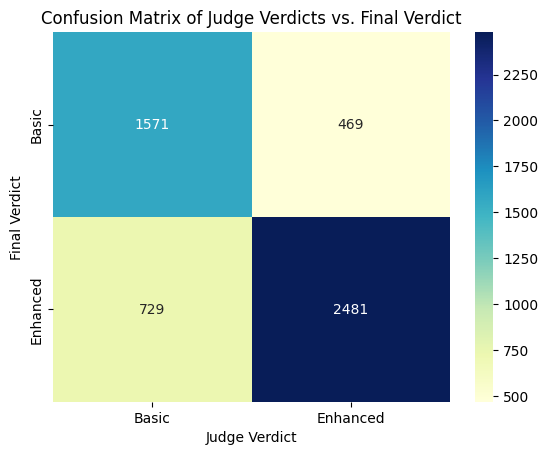

Overall Accuracy of Judges Compared to Final Verdict: 77.18%


In [8]:
def confusion_matrix_analysis(df, judge_columns):
    # Assuming 'Final Verdict' is the ground truth
    all_predictions = df[judge_columns].values.flatten()
    all_true = np.repeat(df['Final Verdict'], len(judge_columns))
    
    cm = confusion_matrix(all_true, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Basic', 'Enhanced'], yticklabels=['Basic', 'Enhanced'])
    plt.xlabel('Judge Verdict')
    plt.ylabel('Final Verdict')
    plt.title('Confusion Matrix of Judge Verdicts vs. Final Verdict')
    plt.show()
    
    # Print overall accuracy
    accuracy = np.mean(all_predictions == all_true)
    print(f"Overall Accuracy of Judges Compared to Final Verdict: {accuracy * 100:.2f}%")

confusion_matrix_analysis(df, judge_columns)

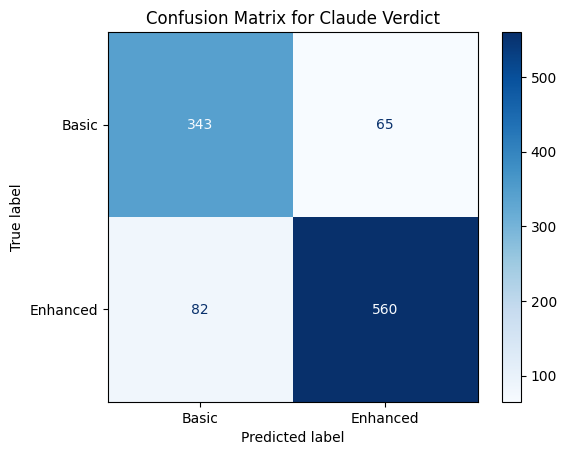

Claude Verdict Accuracy compared to Final Verdict: 86.00%



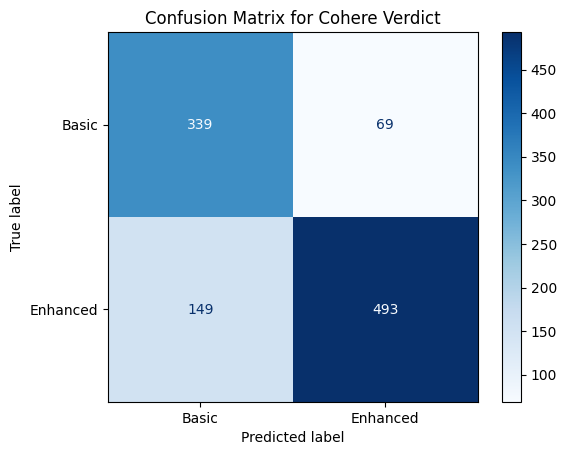

Cohere Verdict Accuracy compared to Final Verdict: 79.24%



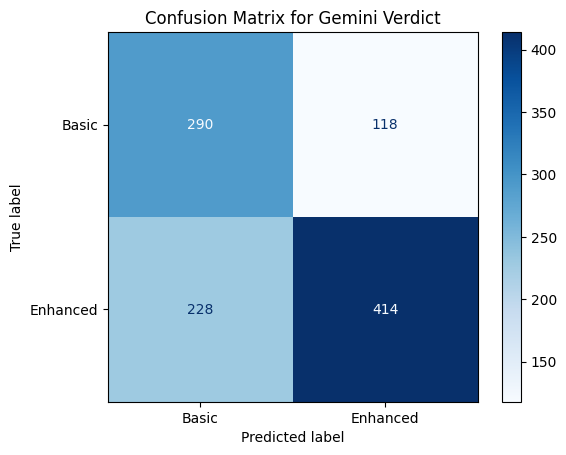

Gemini Verdict Accuracy compared to Final Verdict: 67.05%



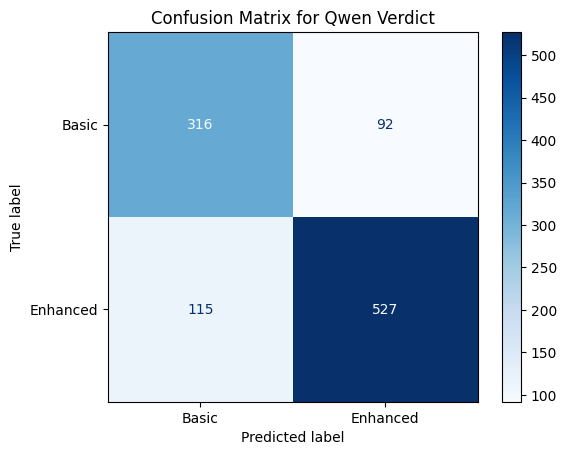

Qwen Verdict Accuracy compared to Final Verdict: 80.29%



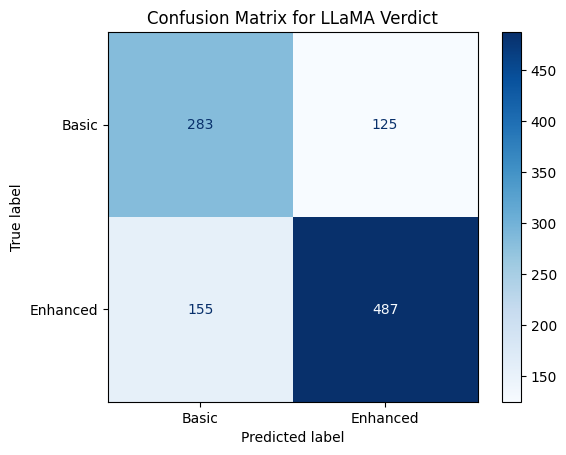

LLaMA Verdict Accuracy compared to Final Verdict: 73.33%



In [9]:

def confusion_matrix_analysis_per_judge(df, judge_columns):
    for judge in judge_columns:
        y_true = df['Final Verdict']
        y_pred = df[judge]
        
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Basic', 'Enhanced'])
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix for {judge}')
        plt.show()
        
        # Calculate accuracy
        accuracy = (y_pred == y_true).mean()
        print(f"{judge} Accuracy compared to Final Verdict: {accuracy * 100:.2f}%\n")

confusion_matrix_analysis_per_judge(df, judge_columns)

#### Judge Removal Analysis

In [10]:
def judge_removal_analysis_modified(df_original, judge_columns):    
    results = []
    
    # Store the original DataFrame to prevent modifications
    df_base = df_original.copy()
    
    # Iterate over each judge
    for removed_judge in judge_columns:
        # Create a copy of the DataFrame
        df = df_base.copy()
        
        # Remove the judge's column
        remaining_judges = [j for j in judge_columns if j != removed_judge]
        df = df.drop(columns=[removed_judge])
        
        # Recalculate 'Final Verdict' based on majority vote
        df['Final Verdict'] = df[remaining_judges].mode(axis=1)[0]
        
        # Recalculate overall performance metrics
        enhanced_win_rate = df['Final Verdict'].mean()
        
        # Binomial test
        enhanced_wins = (df['Final Verdict'] == 1).sum()
        total = len(df)
        result = binomtest(enhanced_wins, n=total, p=0.5, alternative='two-sided')
        
        # Calculate Fleiss' Kappa
        ratings = df[remaining_judges].values
        category_counts = []
        for row in ratings:
            counts = [np.sum(row == 0), np.sum(row == 1)]
            category_counts.append(counts)
        kappa = fleiss_kappa(np.array(category_counts))
        
        # Append results
        result = {
            'Removed Judge': removed_judge,
            'Enhanced Win Rate': enhanced_win_rate,
            'Binomial p-value': result.pvalue,
            'Fleiss Kappa': kappa
        }
        results.append(result)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df


C:\Users\serha\AppData\Local\Temp\ipykernel_5696\2799838008.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Removed Judge', y='Enhanced Win Rate', data=results_df, palette='viridis')


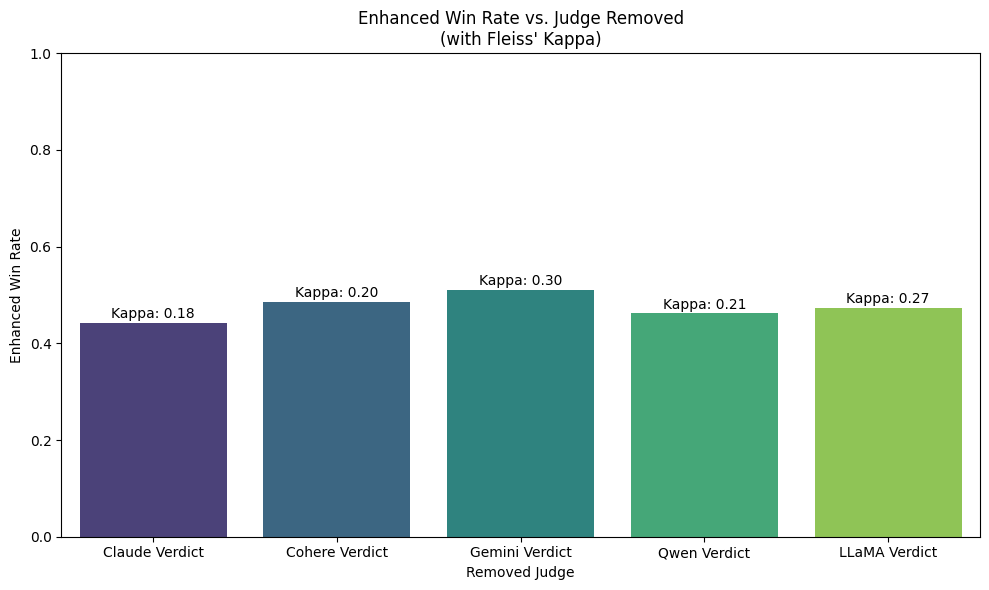

In [11]:
# Run the modified judge removal analysis
results_df = judge_removal_analysis_modified(df, judge_columns)

# Plotting the Enhanced Win Rate with Fleiss' Kappa
plt.figure(figsize=(10, 6))
sns.barplot(x='Removed Judge', y='Enhanced Win Rate', data=results_df, palette='viridis')

# Adding Fleiss' Kappa values as annotations
for index, row in results_df.iterrows():
    plt.text(index, row['Enhanced Win Rate'] + 0.01, f"Kappa: {row['Fleiss Kappa']:.2f}", ha='center')

plt.title('Enhanced Win Rate vs. Judge Removed\n(with Fleiss\' Kappa)')
plt.ylabel('Enhanced Win Rate')
plt.xlabel('Removed Judge')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


C:\Users\serha\AppData\Local\Temp\ipykernel_5696\2619534507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Removed Judge', y='Binomial p-value', data=results_df, palette='magma')


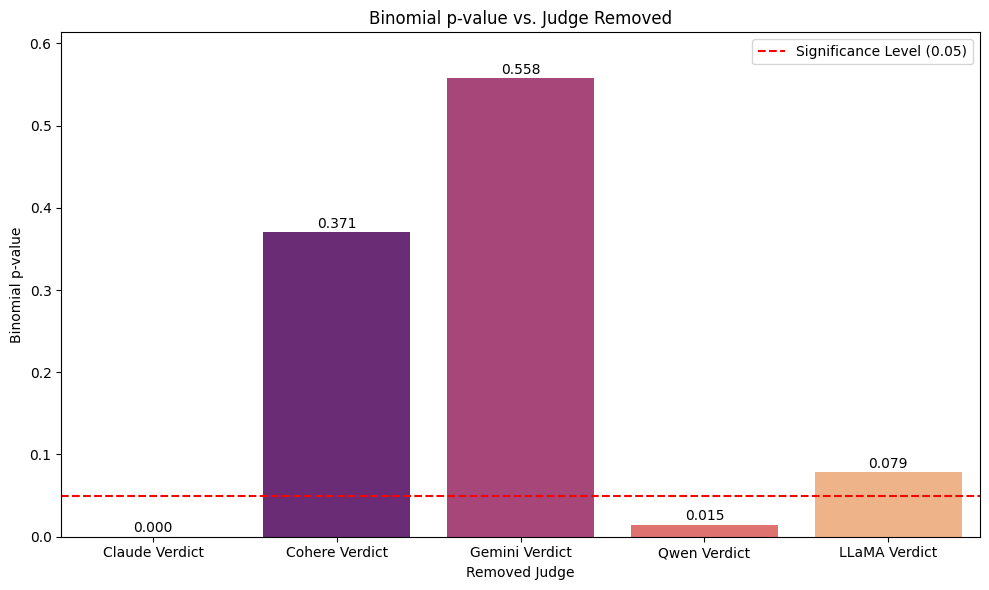

In [12]:
# Plotting the Binomial p-values with significance threshold
plt.figure(figsize=(10, 6))
sns.barplot(x='Removed Judge', y='Binomial p-value', data=results_df, palette='magma')

# Adding significance threshold line
significance_level = 0.05
plt.axhline(significance_level, color='red', linestyle='--', label=f'Significance Level ({significance_level})')

# Annotating bars
for index, row in results_df.iterrows():
    plt.text(index, row['Binomial p-value'] + 0.005, f"{row['Binomial p-value']:.3f}", ha='center')

plt.title('Binomial p-value vs. Judge Removed')
plt.ylabel('Binomial p-value')
plt.xlabel('Removed Judge')
plt.ylim(0, max(results_df['Binomial p-value']) * 1.1)
plt.legend()
plt.tight_layout()
plt.show()


#### Identifying Critical Judges

C:\Users\serha\AppData\Local\Temp\ipykernel_5696\3476143062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_decisions['Winning Verdict'] = np.where(close_decisions['Enhanced Votes'] > close_decisions['Basic Votes'], 1, 0)
C:\Users\serha\AppData\Local\Temp\ipykernel_5696\3476143062.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Judge', y='On Winning Side (%)', data=critical_judges_df, palette='coolwarm')


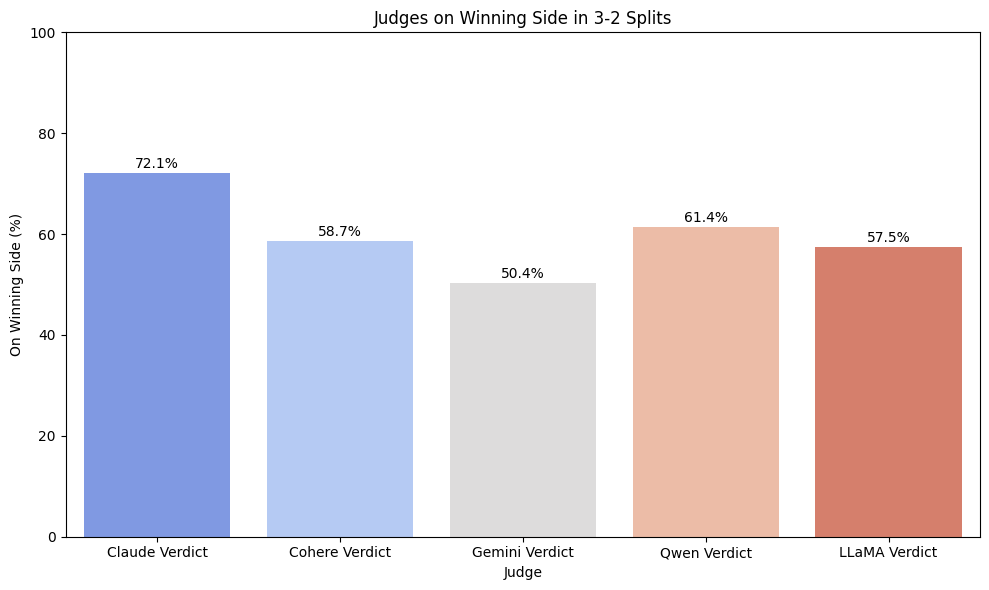

Critical Judges (Proportion of times on winning side in 3-2 splits):
Claude Verdict: 72.1%
Cohere Verdict: 58.7%
Gemini Verdict: 50.4%
Qwen Verdict: 61.4%
LLaMA Verdict: 57.5%


In [13]:
def identify_critical_judges(df, judge_columns):
    # Step 1: Identify instances with 3-2 split
    df['Enhanced Votes'] = df[judge_columns].sum(axis=1)
    df['Basic Votes'] = len(judge_columns) - df['Enhanced Votes']
    
    # Select instances where the decision was 3-2
    close_decisions = df[((df['Enhanced Votes'] == 3) & (df['Basic Votes'] == 2)) | ((df['Enhanced Votes'] == 2) & (df['Basic Votes'] == 3))]
    
    # Determine the winning option for each close decision
    close_decisions['Winning Verdict'] = np.where(close_decisions['Enhanced Votes'] > close_decisions['Basic Votes'], 1, 0)
    
    # Initialize a dictionary to store counts
    judge_on_winning_side = {judge: 0 for judge in judge_columns}
    total_close_cases = len(close_decisions)
    
    # Step 2: For each judge, count how many times they were on the winning side
    for judge in judge_columns:
        # Judge's votes in close decisions
        judge_votes = close_decisions[judge]
        # Compare with the winning verdict
        on_winning_side = judge_votes == close_decisions['Winning Verdict']
        # Sum up the counts
        judge_on_winning_side[judge] = on_winning_side.sum()
    
    # Step 3: Calculate the proportion
    judge_critical_scores = {judge: count / total_close_cases for judge, count in judge_on_winning_side.items()}
    
    # Convert to DataFrame for plotting
    critical_judges_df = pd.DataFrame({
        'Judge': list(judge_critical_scores.keys()),
        'On Winning Side (%)': [score * 100 for score in judge_critical_scores.values()]
    })
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Judge', y='On Winning Side (%)', data=critical_judges_df, palette='coolwarm')
    
    # Annotate bars with exact percentages
    for index, row in critical_judges_df.iterrows():
        plt.text(index, row['On Winning Side (%)'] + 1, f"{row['On Winning Side (%)']:.1f}%", ha='center')
    
    plt.title('Judges on Winning Side in 3-2 Splits')
    plt.ylabel('On Winning Side (%)')
    plt.xlabel('Judge')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    
    # Print the results
    print("Critical Judges (Proportion of times on winning side in 3-2 splits):")
    for judge, score in judge_critical_scores.items():
        print(f"{judge}: {score * 100:.1f}%")


identify_critical_judges(df, judge_columns)

#### Judge Voting Tendencies

Claude Verdict votes for Enhanced 59.52% of the time.
Cohere Verdict votes for Enhanced 53.52% of the time.
Gemini Verdict votes for Enhanced 50.67% of the time.
Qwen Verdict votes for Enhanced 58.95% of the time.
LLaMA Verdict votes for Enhanced 58.29% of the time.


C:\Users\serha\AppData\Local\Temp\ipykernel_5696\682978425.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Judge', y='Enhanced Vote Percentage', data=preferences_df, palette='pastel')


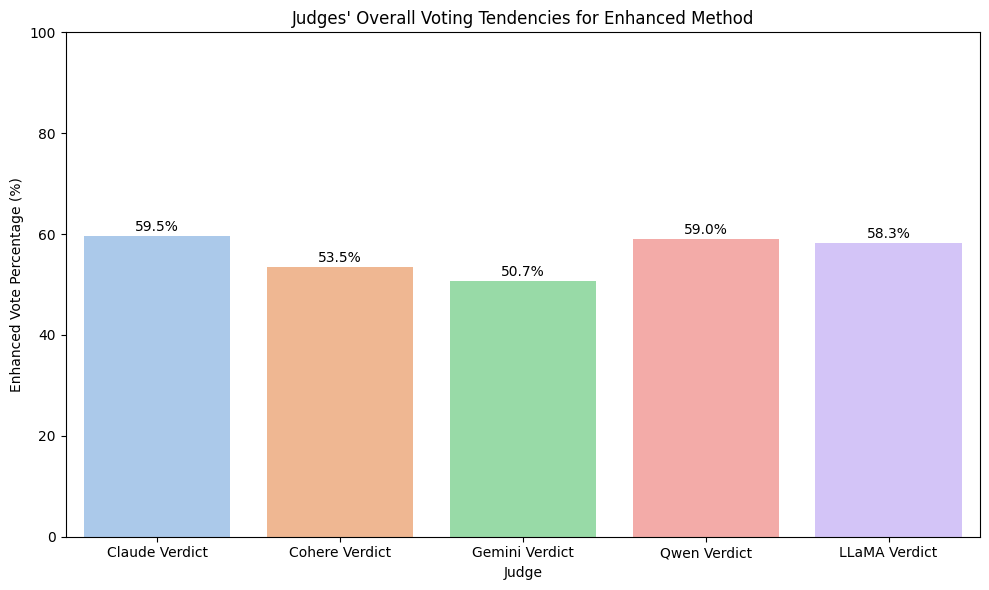

In [14]:
def calculate_judge_voting_tendencies(df, judge_columns):
    judge_preferences = {}
    for judge in judge_columns:
        enhanced_votes = df[judge].sum()
        total_votes = len(df)
        preference = enhanced_votes / total_votes
        judge_preferences[judge] = preference * 100  # Convert to percentage
        print(f"{judge} votes for Enhanced {preference * 100:.2f}% of the time.")
    
    # Plotting the preferences
    preferences_df = pd.DataFrame({
        'Judge': list(judge_preferences.keys()),
        'Enhanced Vote Percentage': list(judge_preferences.values())
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Judge', y='Enhanced Vote Percentage', data=preferences_df, palette='pastel')
    
    # Annotate bars
    for index, row in preferences_df.iterrows():
        plt.text(index, row['Enhanced Vote Percentage'] + 1, f"{row['Enhanced Vote Percentage']:.1f}%", ha='center')
    
    plt.title('Judges\' Overall Voting Tendencies for Enhanced Method')
    plt.ylabel('Enhanced Vote Percentage (%)')
    plt.xlabel('Judge')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

calculate_judge_voting_tendencies(df, judge_columns)

#### Win-Rate Change Analysis

C:\Users\serha\AppData\Local\Temp\ipykernel_5696\1705748141.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Removed Judge', y='Win Rate Change', data=results_df, palette='spring')


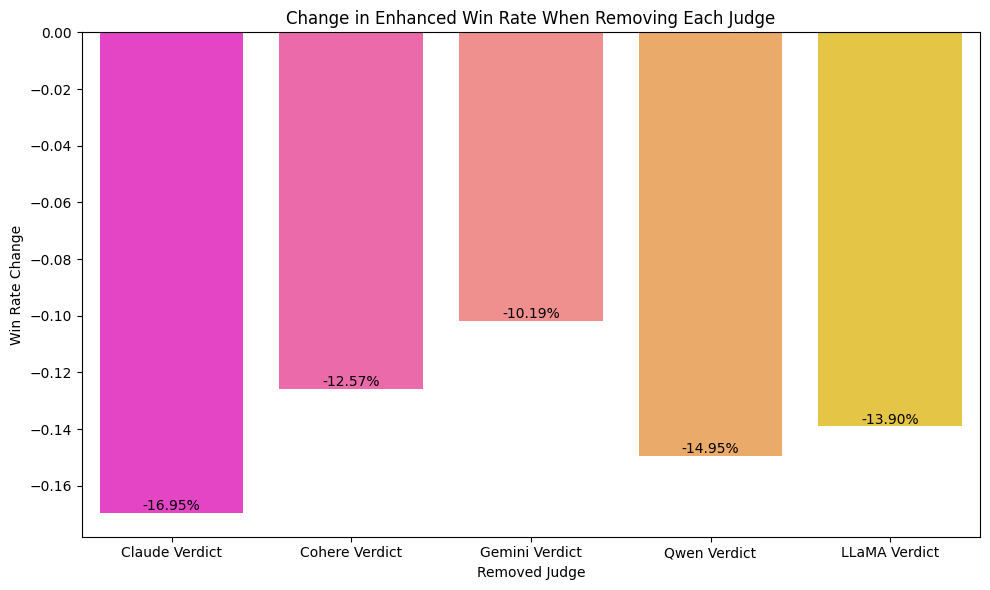

Judges whose removal decreases Enhanced win rate the most:
    Removed Judge  Win Rate Change
0  Claude Verdict        -0.169524
3    Qwen Verdict        -0.149524
4   LLaMA Verdict        -0.139048
1  Cohere Verdict        -0.125714
2  Gemini Verdict        -0.101905


In [15]:
def analyze_win_rate_change(results_df):
    # Calculate the difference in Enhanced win rate when each judge is removed
    original_win_rate = df['Final Verdict'].mean()
    results_df['Win Rate Change'] = results_df['Enhanced Win Rate'] - original_win_rate
    
    # Plotting the win rate change
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Removed Judge', y='Win Rate Change', data=results_df, palette='spring')
    
    # Annotate bars
    for index, row in results_df.iterrows():
        change_percentage = row['Win Rate Change'] * 100
        plt.text(index, row['Win Rate Change'] + 0.001, f"{change_percentage:+.2f}%", ha='center')
    
    plt.title('Change in Enhanced Win Rate When Removing Each Judge')
    plt.ylabel('Win Rate Change')
    plt.xlabel('Removed Judge')
    plt.axhline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Identify judges whose removal decreases the Enhanced win rate the most
    sorted_results = results_df.sort_values('Win Rate Change')
    print("Judges whose removal decreases Enhanced win rate the most:")
    print(sorted_results[['Removed Judge', 'Win Rate Change']])

analyze_win_rate_change(results_df)

#### Identify Pivotal Judges

C:\Users\serha\AppData\Local\Temp\ipykernel_5696\2538029350.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Judge', y='Pivotal Instances (%)', data=pivotal_judges_df, palette='autumn')


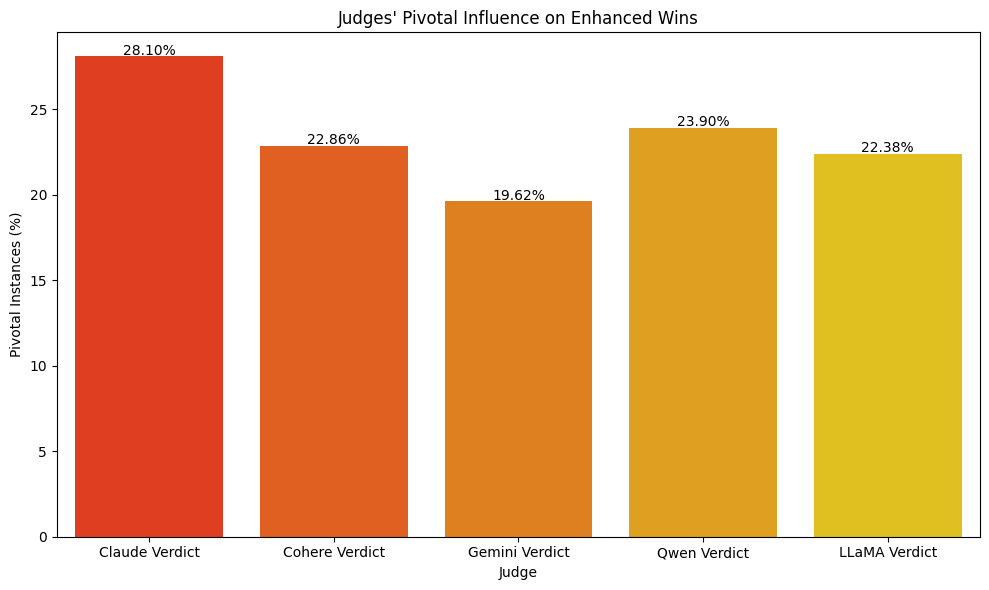

Judges' Pivotal Influence on Enhanced Wins:
Claude Verdict: 28.10% of instances were pivotal
Cohere Verdict: 22.86% of instances were pivotal
Gemini Verdict: 19.62% of instances were pivotal
Qwen Verdict: 23.90% of instances were pivotal
LLaMA Verdict: 22.38% of instances were pivotal


In [16]:
def identify_pivotal_judges(df, judge_columns):
    total_instances = len(df)
    pivotal_counts = {judge: 0 for judge in judge_columns}
    
    for index, row in df.iterrows():
        total_votes = len(judge_columns)
        votes = row[judge_columns]
        enhanced_votes = votes.sum()
        basic_votes = total_votes - enhanced_votes
        final_verdict = row['Final Verdict']
        
        # For each judge, check if their vote changed the outcome
        for judge in judge_columns:
            # Remove the judge's vote
            votes_without_judge = votes.drop(judge)
            enhanced_votes_wo_judge = votes_without_judge.sum()
            basic_votes_wo_judge = total_votes - 1 - enhanced_votes_wo_judge
            
            # Recalculate verdict without this judge
            if enhanced_votes_wo_judge > basic_votes_wo_judge:
                verdict_wo_judge = 1
            elif enhanced_votes_wo_judge < basic_votes_wo_judge:
                verdict_wo_judge = 0
            else:
                # Tie occurs after removing the judge
                # Consider this as a change in verdict
                verdict_wo_judge = -1  # Use -1 to indicate a tie or undecided verdict
                
            if verdict_wo_judge != final_verdict:
                # Judge's vote was pivotal
                pivotal_counts[judge] += 1
                
    # Calculate proportion
    pivotal_proportions = {judge: count / total_instances for judge, count in pivotal_counts.items()}
    
    # Convert to DataFrame for plotting
    pivotal_judges_df = pd.DataFrame({
        'Judge': list(pivotal_proportions.keys()),
        'Pivotal Instances (%)': [prop * 100 for prop in pivotal_proportions.values()]
    })
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Judge', y='Pivotal Instances (%)', data=pivotal_judges_df, palette='autumn')
    
    # Annotate bars
    for index, row in pivotal_judges_df.iterrows():
        plt.text(index, row['Pivotal Instances (%)'] + 0.1, f"{row['Pivotal Instances (%)']:.2f}%", ha='center')
    
    plt.title('Judges\' Pivotal Influence on Enhanced Wins')
    plt.ylabel('Pivotal Instances (%)')
    plt.xlabel('Judge')
    plt.tight_layout()
    plt.show()
    
    # Print the results
    print("Judges' Pivotal Influence on Enhanced Wins:")
    for judge, prop in pivotal_proportions.items():
        print(f"{judge}: {prop * 100:.2f}% of instances were pivotal")


identify_pivotal_judges(df, judge_columns)

#### Final Verdict Correlation

C:\Users\serha\AppData\Local\Temp\ipykernel_5696\1298825648.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Judge', y='Correlation Coefficient', data=correlations_df, palette='cool')


Correlation between Claude Verdict's votes and Final Verdict: 0.71
Correlation between Cohere Verdict's votes and Final Verdict: 0.59
Correlation between Gemini Verdict's votes and Final Verdict: 0.35
Correlation between Qwen Verdict's votes and Final Verdict: 0.59
Correlation between LLaMA Verdict's votes and Final Verdict: 0.45


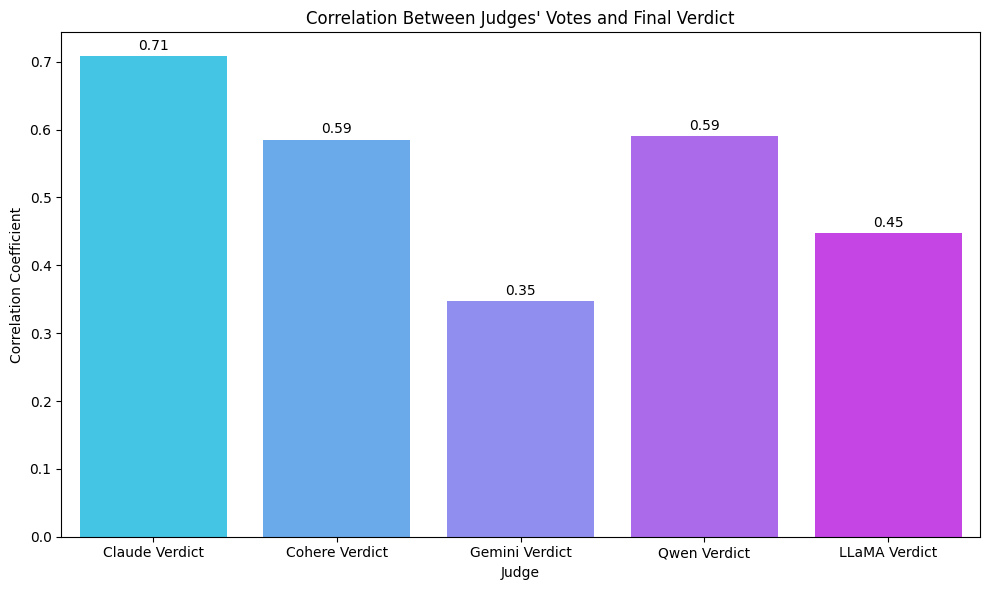

In [17]:
def calculate_judge_final_verdict_correlation(df, judge_columns):
    correlations = {}
    for judge in judge_columns:
        correlation = df[judge].corr(df['Final Verdict'])
        correlations[judge] = correlation
        print(f"Correlation between {judge}'s votes and Final Verdict: {correlation:.2f}")
    
    # Convert to DataFrame for plotting
    correlations_df = pd.DataFrame({
        'Judge': list(correlations.keys()),
        'Correlation Coefficient': list(correlations.values())
    })
    
    # Plotting the correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Judge', y='Correlation Coefficient', data=correlations_df, palette='cool')
    
    # Annotate bars
    for index, row in correlations_df.iterrows():
        plt.text(index, row['Correlation Coefficient'] + 0.01, f"{row['Correlation Coefficient']:.2f}", ha='center')
    
    plt.title('Correlation Between Judges\' Votes and Final Verdict')
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Judge')
    plt.tight_layout()
    plt.show()

calculate_judge_final_verdict_correlation(df, judge_columns)

## Part 2

### Identify where the Enhanced and Basic generations are the same

#### 1) Only ignoring letter cases:

In [18]:
import string

def normalize_text_case_only(text):
    # Convert to lowercase
    text = text.lower()
    # Return the text as-is without further normalization
    return text

def find_identical_questions_case_sensitive(df):
    # Normalize the questions by converting to lowercase only
    df['Basic Question Normalized'] = df['Basic Question'].apply(normalize_text_case_only)
    df['Enhanced Question Normalized'] = df['Enhanced Question'].apply(normalize_text_case_only)
    
    # Identify rows where normalized questions are the same
    df['Questions Same'] = df['Basic Question Normalized'] == df['Enhanced Question Normalized']
    
    # Get the cases where questions are the same
    same_questions_df = df[df['Questions Same']]
    
    # Print the number and percentage of identical questions
    total_instances = len(df)
    identical_count = len(same_questions_df)
    identical_percentage = (identical_count / total_instances) * 100
    print(f"Number of instances where 'Basic Question' and 'Enhanced Question' are identical (ignoring case): {identical_count}")
    print(f"Percentage of total instances: {identical_percentage:.2f}%")
    
    # Among the identical questions, count how many times the LLMs chose 'Basic' and 'Enhanced'
    verdict_counts = same_questions_df['Final Verdict'].value_counts()
    basic_count = verdict_counts.get(0, 0)
    enhanced_count = verdict_counts.get(1, 0)
    
    print(f"\nAmong the identical questions:")
    print(f"Number of times LLMs chose 'Basic': {basic_count}")
    print(f"Number of times LLMs chose 'Enhanced': {enhanced_count}")
    
    # Calculate percentages
    if identical_count > 0:
        basic_percentage = (basic_count / identical_count) * 100
        enhanced_percentage = (enhanced_count / identical_count) * 100
        print(f"Percentage of 'Basic' choices: {basic_percentage:.2f}%")
        print(f"Percentage of 'Enhanced' choices: {enhanced_percentage:.2f}%")
    
    # Optionally, display some examples
    print("\nExamples of identical questions (ignoring case):")
    display(same_questions_df[['Index', 'Basic Question', 'Enhanced Question', 'Final Verdict']].head(5))


In [19]:
find_identical_questions_case_sensitive(df)

Number of instances where 'Basic Question' and 'Enhanced Question' are identical (ignoring case): 16
Percentage of total instances: 1.52%

Among the identical questions:
Number of times LLMs chose 'Basic': 5
Number of times LLMs chose 'Enhanced': 11
Percentage of 'Basic' choices: 31.25%
Percentage of 'Enhanced' choices: 68.75%

Examples of identical questions (ignoring case):


,Index,Basic Question,Enhanced Question,Final Verdict
184,86474,What was the name of the supercontinent that b...,What was the name of the supercontinent that b...,1
236,61213,What was the total number of princely states i...,What was the total number of princely states i...,1
350,20676,During which period were the majority of the A...,During which period were the majority of the A...,1
392,72309,Into which ocean does Charleston Harbor open?,Into which ocean does Charleston Harbor open?,0
415,53264,How many siblings did Von Neumann have?,How many siblings did Von Neumann have?,1


In the 'Final Verdict' column, 1 is Enhanced generation and 0 is Basic generation.

#### 2) Also ignoring 'the', 'a', 'an', and other basic stopwords.

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize words
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Rejoin tokens
    normalized_text = ' '.join(tokens)
    return normalized_text

def find_identical_questions(df):
    # Normalize the questions
    df['Basic Question Normalized'] = df['Basic Question'].apply(normalize_text)
    df['Enhanced Question Normalized'] = df['Enhanced Question'].apply(normalize_text)
    
    # Identify rows where normalized questions are the same
    df['Questions Same'] = df['Basic Question Normalized'] == df['Enhanced Question Normalized']
    
    # Get the cases where questions are the same
    same_questions_df = df[df['Questions Same']]
    
    # Print the number and percentage of identical questions
    total_instances = len(df)
    identical_count = len(same_questions_df)
    identical_percentage = (identical_count / total_instances) * 100
    print(f"Number of instances where 'Basic Question' and 'Enhanced Question' are the same: {identical_count}")
    print(f"Percentage of total instances: {identical_percentage:.2f}%")
    
    # Among the identical questions, count how many times the LLMs chose 'Basic' and 'Enhanced'
    verdict_counts = same_questions_df['Final Verdict'].value_counts()
    basic_count = verdict_counts.get(0, 0)
    enhanced_count = verdict_counts.get(1, 0)
    
    print(f"\nAmong the identical questions:")
    print(f"Number of times LLMs chose 'Basic': {basic_count}")
    print(f"Number of times LLMs chose 'Enhanced': {enhanced_count}")
    
    # Calculate percentages
    if identical_count > 0:
        basic_percentage = (basic_count / identical_count) * 100
        enhanced_percentage = (enhanced_count / identical_count) * 100
        print(f"Percentage of 'Basic' choices: {basic_percentage:.2f}%")
        print(f"Percentage of 'Enhanced' choices: {enhanced_percentage:.2f}%")
    
    # Optionally, display some examples
    print("\nExamples of identical questions:")
    display(same_questions_df[['Index', 'Basic Question', 'Enhanced Question', 'Question Order', 'Final Verdict']].head(20))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\serha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
find_identical_questions(df)

Number of instances where 'Basic Question' and 'Enhanced Question' are the same: 20
Percentage of total instances: 1.90%

Among the identical questions:
Number of times LLMs chose 'Basic': 7
Number of times LLMs chose 'Enhanced': 13
Percentage of 'Basic' choices: 35.00%
Percentage of 'Enhanced' choices: 65.00%

Examples of identical questions:


,Index,Basic Question,Enhanced Question,Question Order,Final Verdict
184,86474,What was the name of the supercontinent that b...,What was the name of the supercontinent that b...,enhanced_first,1
236,61213,What was the total number of princely states i...,What was the total number of princely states i...,enhanced_first,1
285,63788,During which month does Estonia experience its...,In which month does Estonia experience its hig...,basic_first,0
350,20676,During which period were the majority of the A...,During which period were the majority of the A...,enhanced_first,1
392,72309,Into which ocean does Charleston Harbor open?,Into which ocean does Charleston Harbor open?,basic_first,0
415,53264,How many siblings did Von Neumann have?,How many siblings did Von Neumann have?,enhanced_first,1
462,56959,In which decade did the Florida land boom take...,In which decade did the Florida land boom take...,enhanced_first,1
533,30784,Did adolescent drug use decrease or increase f...,Did adolescent drug use decrease or increase f...,enhanced_first,1
564,6582,How does Buddhism define the concept of imperm...,How does Buddhism define the concept of imperm...,basic_first,1
586,63517,On what date did President Obama deliver a tel...,On what date did President Obama deliver a tel...,basic_first,0


### Analyzing Answer Matches in Enhanced vs Basic Generation Wins

#### 1) Exact Matches

Overall Basic Answer match count: 404
Overall Basic Answer match percentage: 38.48%
Overall Enhanced Answer match count: 430
Overall Enhanced Answer match percentage: 40.95%

Among instances where LLMs chose the Enhanced generation:
Total instances: 642
Enhanced Answer match count: 262
Enhanced Answer match percentage: 40.81%

Among instances where LLMs chose the Basic generation:
Total instances: 408
Basic Answer match count: 155
Basic Answer match percentage: 37.99%


C:\Users\serha\AppData\Local\Temp\ipykernel_5696\1700253310.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Generation Chosen', y='Answer Match Percentage', data=match_data, palette='Set2')


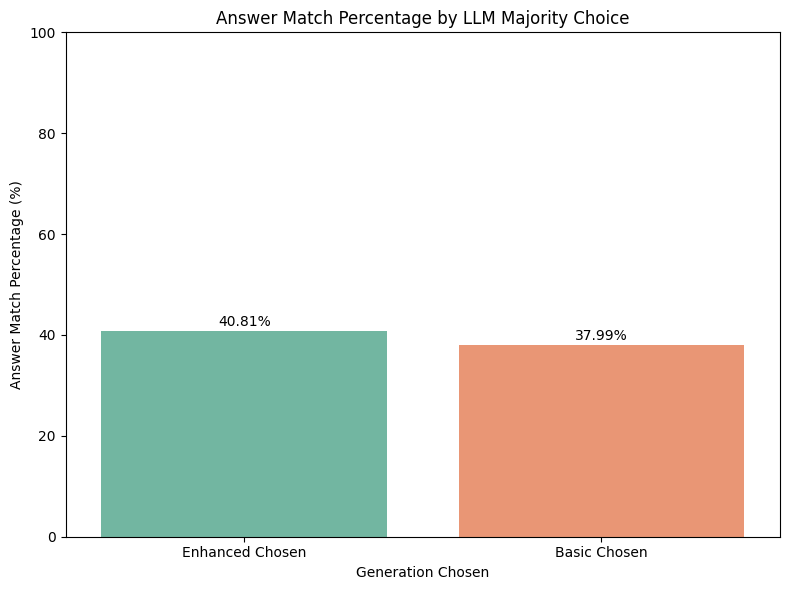

In [22]:
def calculate_answer_matches(df):
    # Normalize answers by converting to lowercase and stripping whitespace
    df['Basic Answer Normalized'] = df['Basic Answer'].str.lower().str.strip()
    df['Enhanced Answer Normalized'] = df['Enhanced Answer'].str.lower().str.strip()
    df['Original Answer Normalized'] = df['Original Answer'].str.lower().str.strip()
    
    # Compare Basic Answer to Original Answer
    df['Basic Answer Match'] = df['Basic Answer Normalized'] == df['Original Answer Normalized']
    
    # Compare Enhanced Answer to Original Answer
    df['Enhanced Answer Match'] = df['Enhanced Answer Normalized'] == df['Original Answer Normalized']
    
    # Calculate overall match percentages
    total_instances = len(df)
    basic_match_count = df['Basic Answer Match'].sum()
    enhanced_match_count = df['Enhanced Answer Match'].sum()
    
    basic_match_percentage = (basic_match_count / total_instances) * 100
    enhanced_match_percentage = (enhanced_match_count / total_instances) * 100
    
    print(f"Overall Basic Answer match count: {basic_match_count}")
    print(f"Overall Basic Answer match percentage: {basic_match_percentage:.2f}%")
    print(f"Overall Enhanced Answer match count: {enhanced_match_count}")
    print(f"Overall Enhanced Answer match percentage: {enhanced_match_percentage:.2f}%")
    
    # Determine which generation was chosen by the majority of LLMs
    df['LLM Majority Choice'] = np.where(df['Final Verdict'] == 1, 'Enhanced', 'Basic')
    
    # Answer match percentages among rows where LLMs chose Enhanced generation
    enhanced_chosen_df = df[df['LLM Majority Choice'] == 'Enhanced']
    enhanced_chosen_total = len(enhanced_chosen_df)
    enhanced_chosen_match_count = enhanced_chosen_df['Enhanced Answer Match'].sum()
    enhanced_chosen_match_percentage = (enhanced_chosen_match_count / enhanced_chosen_total) * 100
    
    print(f"\nAmong instances where LLMs chose the Enhanced generation:")
    print(f"Total instances: {enhanced_chosen_total}")
    print(f"Enhanced Answer match count: {enhanced_chosen_match_count}")
    print(f"Enhanced Answer match percentage: {enhanced_chosen_match_percentage:.2f}%")
    
    # Answer match percentages among rows where LLMs chose Basic generation
    basic_chosen_df = df[df['LLM Majority Choice'] == 'Basic']
    basic_chosen_total = len(basic_chosen_df)
    basic_chosen_match_count = basic_chosen_df['Basic Answer Match'].sum()
    basic_chosen_match_percentage = (basic_chosen_match_count / basic_chosen_total) * 100
    
    print(f"\nAmong instances where LLMs chose the Basic generation:")
    print(f"Total instances: {basic_chosen_total}")
    print(f"Basic Answer match count: {basic_chosen_match_count}")
    print(f"Basic Answer match percentage: {basic_chosen_match_percentage:.2f}%")
    
    # Optionally, plot the results
    match_data = pd.DataFrame({
        'Generation Chosen': ['Enhanced Chosen', 'Basic Chosen'],
        'Answer Match Percentage': [enhanced_chosen_match_percentage, basic_chosen_match_percentage]
    })
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Generation Chosen', y='Answer Match Percentage', data=match_data, palette='Set2')
    plt.title('Answer Match Percentage by LLM Majority Choice')
    plt.ylabel('Answer Match Percentage (%)')
    plt.ylim(0, 100)
    
    # Annotate bars with exact percentages
    for index, row in match_data.iterrows():
        plt.text(index, row['Answer Match Percentage'] + 1, f"{row['Answer Match Percentage']:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.show()

calculate_answer_matches(df)

#### 2) Average Edit Distance

In [23]:
def normalized_edit_distance(s1, s2):
    """
    Calculate the normalized Levenshtein edit distance between two strings.
    """
    if not isinstance(s1, str) or not isinstance(s2, str):
        return np.nan  # Handle cases where input is not a string
    distance = Levenshtein.distance(s1, s2)
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 0.0  # Both strings are empty
    normalized_distance = distance / max_len
    return normalized_distance

def calculate_answer_similarity(df):
    # Normalize answers by converting to lowercase and stripping whitespace
    df['Basic Answer Normalized'] = df['Basic Answer'].str.lower().str.strip()
    df['Enhanced Answer Normalized'] = df['Enhanced Answer'].str.lower().str.strip()
    df['Original Answer Normalized'] = df['Original Answer'].str.lower().str.strip()
    
    # Calculate normalized edit distance for Basic Answer
    df['Basic Answer Distance'] = df.apply(
        lambda row: normalized_edit_distance(row['Basic Answer Normalized'], row['Original Answer Normalized']), axis=1
    )
    
    # Calculate normalized edit distance for Enhanced Answer
    df['Enhanced Answer Distance'] = df.apply(
        lambda row: normalized_edit_distance(row['Enhanced Answer Normalized'], row['Original Answer Normalized']), axis=1
    )
    
    # Compute average normalized edit distances
    basic_avg_distance = df['Basic Answer Distance'].mean()
    enhanced_avg_distance = df['Enhanced Answer Distance'].mean()
    
    print(f"Average normalized edit distance for Basic Answers: {basic_avg_distance:.4f}")
    print(f"Average normalized edit distance for Enhanced Answers: {enhanced_avg_distance:.4f}")
    
    # Lower distance indicates higher similarity, so we can compute similarity scores
    basic_avg_similarity = 1 - basic_avg_distance
    enhanced_avg_similarity = 1 - enhanced_avg_distance
    
    print(f"\nAverage similarity score for Basic Answers: {basic_avg_similarity:.4f}")
    print(f"Average similarity score for Enhanced Answers: {enhanced_avg_similarity:.4f}")
    
    # Analyze similarity among instances where LLMs chose Enhanced vs. Basic
    df['LLM Majority Choice'] = np.where(df['Final Verdict'] == 1, 'Enhanced', 'Basic')
    
    # Similarity scores among instances where LLMs chose Enhanced generation
    enhanced_chosen_df = df[df['LLM Majority Choice'] == 'Enhanced']
    enhanced_chosen_similarity = 1 - enhanced_chosen_df['Enhanced Answer Distance'].mean()
    
    # Similarity scores among instances where LLMs chose Basic generation
    basic_chosen_df = df[df['LLM Majority Choice'] == 'Basic']
    basic_chosen_similarity = 1 - basic_chosen_df['Basic Answer Distance'].mean()
    
    print(f"\nAverage similarity score for Enhanced Answers among instances where LLMs chose Enhanced: {enhanced_chosen_similarity:.4f}")
    print(f"Average similarity score for Basic Answers among instances where LLMs chose Basic: {basic_chosen_similarity:.4f}")
    
    # Visualize the results
    similarity_data = pd.DataFrame({
        'Answer Type': ['Enhanced Answers', 'Basic Answers'],
        'Average Similarity Score': [enhanced_avg_similarity * 100, basic_avg_similarity * 100]
    })
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Answer Type', y='Average Similarity Score', data=similarity_data, palette='Set3')
    plt.title('Average Similarity Score of Answers to Original Answer')
    plt.ylabel('Average Similarity Score (%)')
    plt.ylim(0, 100)
    
    # Annotate bars with exact percentages
    for index, row in similarity_data.iterrows():
        plt.text(index, row['Average Similarity Score'] + 1, f"{row['Average Similarity Score']:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize similarity scores based on LLM Majority Choice
    choice_similarity_data = pd.DataFrame({
        'LLM Majority Choice': ['Enhanced Chosen', 'Basic Chosen'],
        'Average Similarity Score': [enhanced_chosen_similarity * 100, basic_chosen_similarity * 100]
    })
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='LLM Majority Choice', y='Average Similarity Score', data=choice_similarity_data, palette='Set2')
    plt.title('Average Similarity Score Based on LLM Majority Choice')
    plt.ylabel('Average Similarity Score (%)')
    plt.ylim(0, 100)
    
    # Annotate bars with exact percentages
    for index, row in choice_similarity_data.iterrows():
        plt.text(index, row['Average Similarity Score'] + 1, f"{row['Average Similarity Score']:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.show()


Average normalized edit distance for Basic Answers: 0.3038
Average normalized edit distance for Enhanced Answers: 0.2768

Average similarity score for Basic Answers: 0.6962
Average similarity score for Enhanced Answers: 0.7232

Average similarity score for Enhanced Answers among instances where LLMs chose Enhanced: 0.7091
Average similarity score for Basic Answers among instances where LLMs chose Basic: 0.6830


C:\Users\serha\AppData\Local\Temp\ipykernel_5696\4259051595.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Answer Type', y='Average Similarity Score', data=similarity_data, palette='Set3')


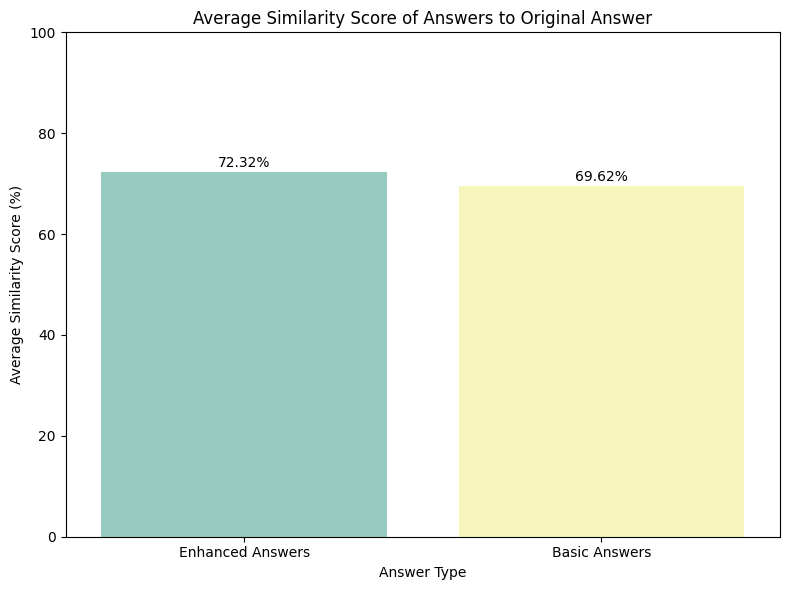

C:\Users\serha\AppData\Local\Temp\ipykernel_5696\4259051595.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LLM Majority Choice', y='Average Similarity Score', data=choice_similarity_data, palette='Set2')


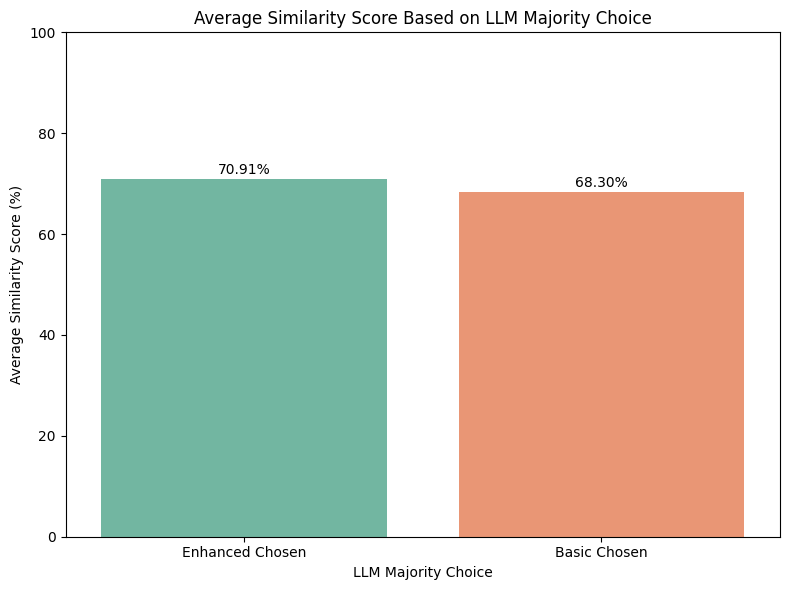

In [24]:
# Call the function to perform the similarity analysis
calculate_answer_similarity(df)